Final Project 2


* Student name: Reuben Hough
* Student pace: full time
* Scheduled project review date/time: 8/03/20
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


Data Science King County Housing Price

In this project, I'm going to get the data, clean it, get useful information from it, model the data with linear regression, then interpret the results so they will be useful. The first step is importing libraries that I will use.

## Importing libraries

In [1]:
import sqlite3
import pandas as pd
from pandas.plotting import scatter_matrix
import pickle
import numpy as np
import matplotlib.pyplot
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from glob import glob
import os
import seaborn as sns
import warnings
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as smf
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, Normalizer, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_validate
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, make_scorer, auc, accuracy_score, roc_curve
from sklearn.svm import LinearSVC, SVR
from itertools import combinations
%matplotlib inline

## Opening and reading data

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


# Data Observation and Editing

There are clearly null values in the data that need to be dealt with before any kind of assesment is done, but first I will find out what they represent.

Null values exist in the "waterfront", "yr_renovated" and "view" categories, with "?" appearing in the data for "sq_basement"

In [3]:
print(df['waterfront'].value_counts(dropna=False))

0.0    19075
NaN     2376
1.0      146
Name: waterfront, dtype: int64


Waterfront refers to whether the property is found on the waterfront "1" or not, "0". With the vast majority of properties not on the waterfront, I believe it is warranted to replace null values with zero.

In [4]:
print(df['yr_renovated'].value_counts(dropna=False))

0.0       17011
NaN        3842
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64


It would be inappropriate to replace the null values in the year renovated category with any value other than zero. Since again the vast majority of houses have not been renovated (Indicated by zero), I beleive it would be appropriate to replace null values with zero.

## Dealing with null values

In [5]:
# Null values in the waterfront and yr_renovated columns are replaced with zero as stated
df.waterfront.replace(np.NaN, 0.0, inplace=True)
df.yr_renovated.replace(np.NaN, 0.0, inplace=True)

In [6]:
# yr_renovated is turned into integer value
df.yr_renovated = df.yr_renovated.apply(lambda x: int(x))

I've found conflicting data on what "view" represents. It may be the number of times a house has been viewed, or an assessment of the view from the house. Either way, I will not be using this because both are somewhat arbitrary, so it will be dropped.

In [7]:
df.drop(['view'], axis=1, inplace=True)

## Replacing basement values

There are question marks in the data; thankfully it can all be replaced by subtracting the "above" square footage from total so there is no guessing involved.


In [8]:
df.sqft_basement = (df.sqft_living - df.sqft_above)

## Editing the date

In [9]:
# Making the Sale Date more useable
df['Year'] = df['date'].map(lambda x: '{}'.format(x[-4:].replace('/', '')))
df['Month'] = df['date'].map(lambda x: '{}'.format(x[:2].replace('/', '')))
df['Day'] = df['date'].map(lambda x: '{}'.format(x[-7:-5].replace('/', '')))
df['Day'] = df['Day'].map(lambda x: int(x))
df['Month'] = df['Month'].map(lambda x: int(x))
df['Year'] = df['Year'].map(lambda x: int(x))

In [10]:
# Making a function that turns the new date columns into a julian date
def julian(a,b,c):
    w=[]
    for x,y,z in zip(a,b,c):
         w.append(pd.Timestamp(year = x,  month = y, day = z).to_julian_date())
    return w

In [11]:
# Turning the date into a Julian date to make it more useable
df['Julian'] = julian(df['Year'], df['Month'], df['Day'])
df.sort_values(by='Julian')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Year,Month,Day,Julian
7316,2202500290,5/2/2014,435000.0,4,1.00,1450,8800,1.0,0.0,4,...,0,98006,47.5746,-122.135,1260,8942,2014,5,2,2456779.5
20586,7853361370,5/2/2014,555000.0,4,2.50,3310,6500,2.0,0.0,3,...,0,98065,47.5150,-121.870,2380,5000,2014,5,2,2456779.5
1040,7197300105,5/2/2014,550000.0,4,2.50,1940,10500,1.0,0.0,4,...,0,98052,47.6830,-122.114,2200,10500,2014,5,2,2456779.5
20543,3438501320,5/2/2014,295000.0,2,2.50,1630,1368,2.0,0.0,3,...,0,98106,47.5489,-122.363,1590,2306,2014,5,2,2456779.5
9587,472000620,5/2/2014,790000.0,3,2.50,2600,4750,1.0,0.0,4,...,0,98117,47.6833,-122.400,2380,4750,2014,5,2,2456779.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19381,8149600265,5/14/2015,725000.0,4,1.75,1980,5850,1.0,0.0,4,...,0,98116,47.5607,-122.391,1810,5850,2015,5,14,2457156.5
12623,4166600610,5/14/2015,335000.0,3,2.00,1410,44866,1.0,0.0,4,...,0,98023,47.3273,-122.370,2950,29152,2015,5,14,2457156.5
5632,7923600250,5/15/2015,450000.0,5,2.00,1870,7344,1.5,0.0,3,...,0,98007,47.5951,-122.144,1870,7650,2015,5,15,2457157.5
13040,5101400871,5/24/2015,445500.0,2,1.75,1390,6670,1.0,0.0,3,...,0,98115,47.6914,-122.308,920,6380,2015,5,24,2457166.5


Looking at the data for any obvious errors

In [12]:
print(df.describe())
print(df.info())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront     condition         grade  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  21597.000000   
mean   1.509941e+04      1.494096      0.006760      3.409825      7.657915   
std    4.141264e+04      0.539683      0.081944    

33 bedrooms is almost certainly an error based on the square footage; it's probably meant to be 3, but I'm uncertain so it will be dropped

In [13]:
df = df.drop([15856])

## Checking for duplicate entries

In [14]:
# There are none
df.duplicated(keep=False).sum()

0

# Creating Data

## Making a new catergory "Seattle" That contains all zip codes within the greater Seattle area

In [15]:
# list found on seattlearea.com/zip-codes/
seattle = [98003, 98005, 98033, 98037, 98040, 98052, 98055, 98101, 98101, 98102,
            98103, 98103, 98103, 98104, 98104, 98105, 98105, 98107, 98109,
            98109, 98110, 98110, 98116, 98116, 98118, 98121, 98125, 98144, 98199]

In [16]:
# Creating category with a 1 if in Seattle and 0 if not
df['Seattle'] = df['zipcode'].apply(lambda x: 1 if x in seattle else 0)

## Binning Month by Season

In [17]:
# Puts december next to other winter months
forbin = df['Month'].replace(12,0)

In [18]:
monthbins = [0,3,6,9,11]
seasonlabels = ['Winter', 'Spring', 'Summer', 'Autumn']
binmonth = pd.cut(forbin, monthbins, labels = seasonlabels, include_lowest = True).cat.as_unordered()

Text(0, 0.5, 'Houses Sold')

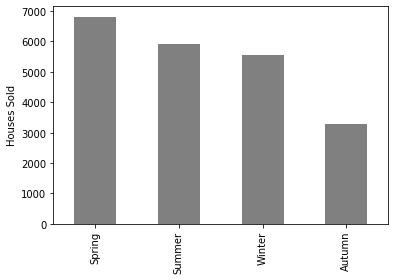

In [19]:
binmonth.value_counts().plot(kind='bar',color='gray')
plt.ylabel('Houses Sold')

In [20]:
df['season'] = binmonth

Creating "basement" as a category for houses with a basement

In [21]:
df['basement'] = df['sqft_basement'].astype(bool).astype(int)

# Relationship between size of a house and lot and the size of its neighbors

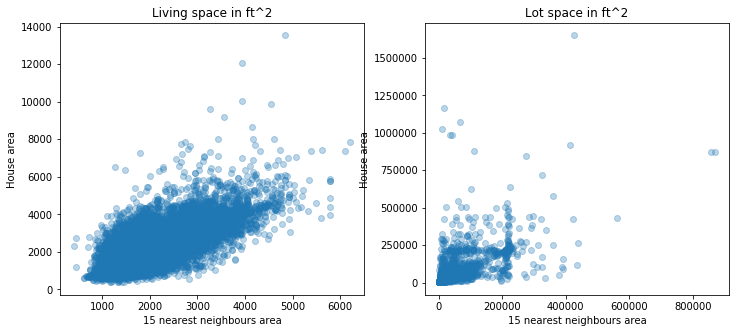

In [22]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
ax1.scatter(df['sqft_living15'], df['sqft_living'], alpha = 0.3);
ax1.set_title('Living space in ft^2');
ax1.set_xlabel('15 nearest neighbours area');
ax1.set_ylabel('House area');

ax1 = fig.add_subplot(122)
ax1.scatter(df['sqft_lot15'], df['sqft_lot'], alpha = 0.3);
ax1.set_title('Lot space in ft^2');
ax1.set_xlabel('15 nearest neighbours area');
ax1.set_ylabel('House area');

# Checking for Correlations in the Data to Eliminate Multicollinearity

These are subplots comparing price to several different factors

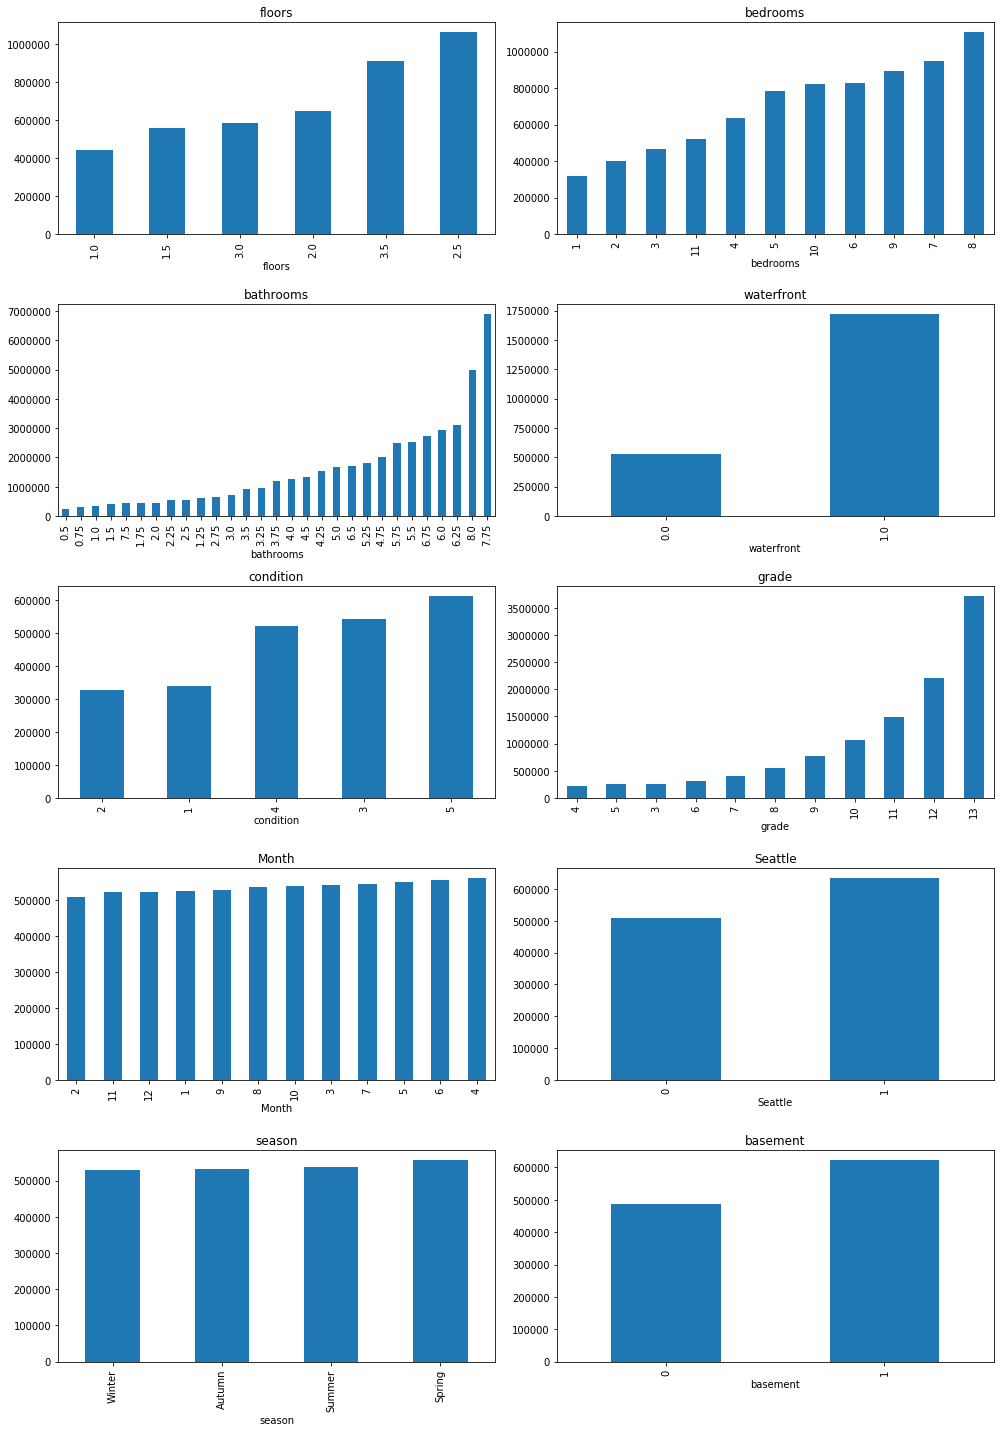

In [23]:
variables = ['floors', 'bedrooms', 'bathrooms','waterfront','condition','grade','Month','Seattle','season','basement']
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,20))

for column, ax in zip(variables, axes.flatten()):
    (df.groupby(column).mean()['price'].sort_values().plot.bar(ax=ax))                
    
    ax.set_title(column)
    
fig.tight_layout()

Log transforming the price may the data easier to work with

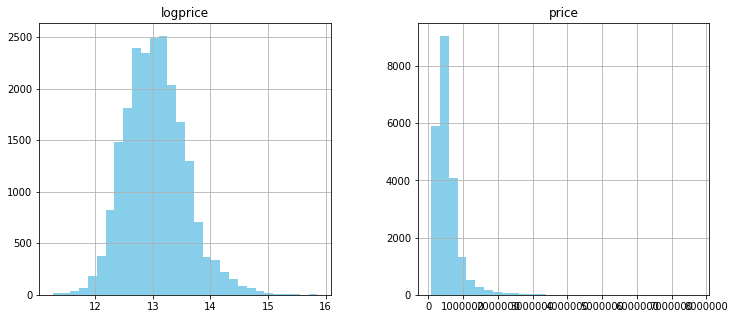

In [24]:
df['logprice'] = np.log(df['price'])
df[['price', 'logprice']].hist(figsize=(12,5),bins=30,color = "skyblue");

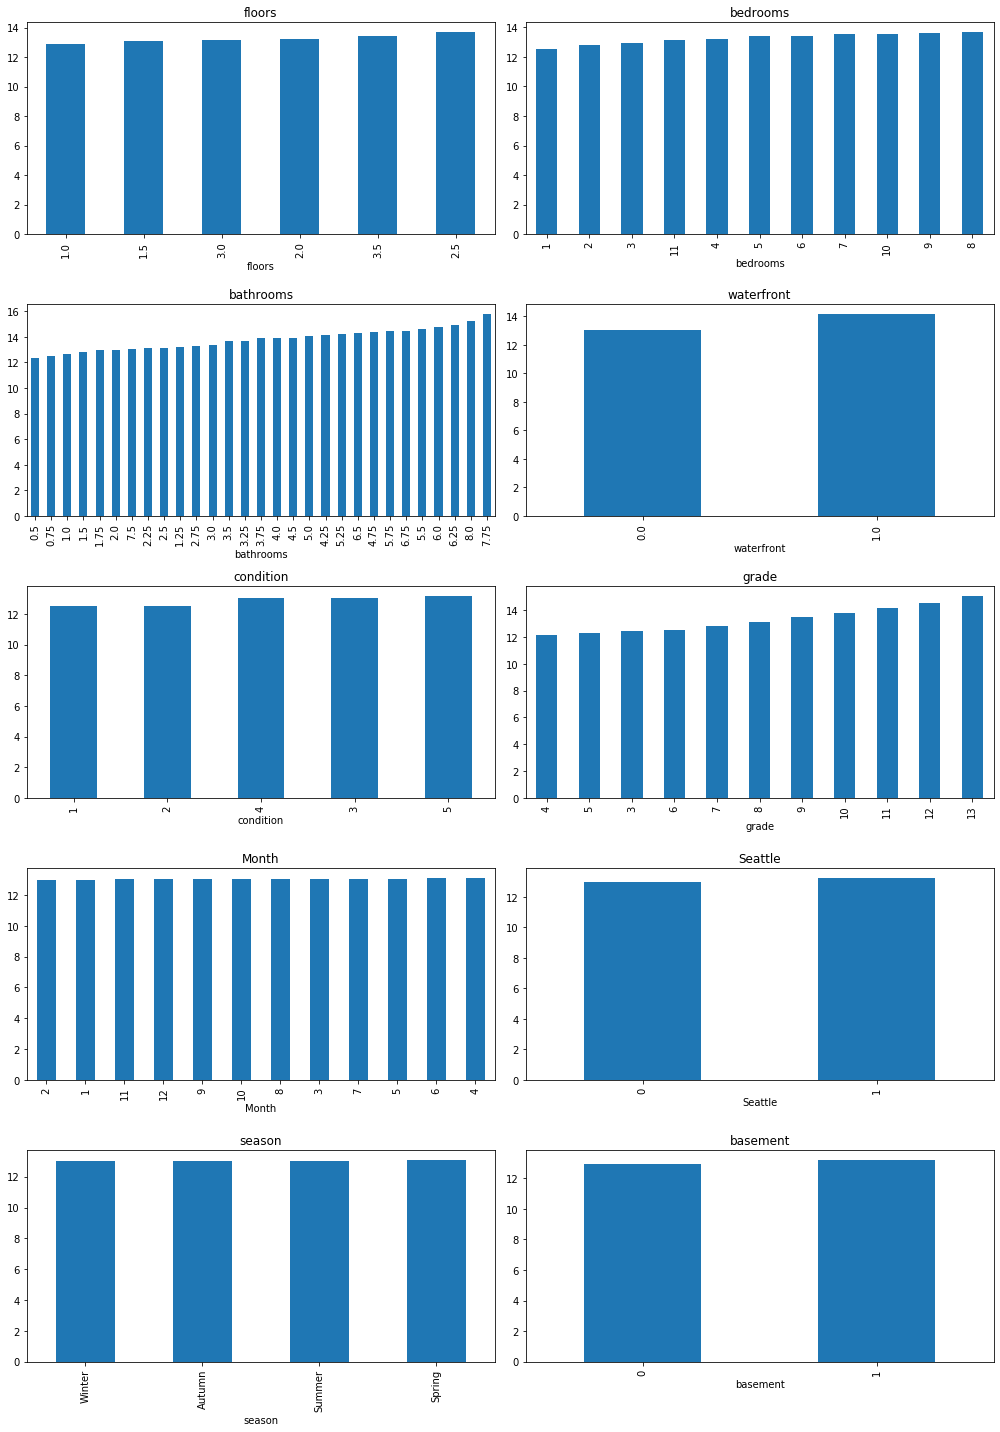

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,20))

for column, ax in zip(variables, axes.flatten()):
    (df.groupby(column).mean()['logprice'].sort_values().plot.bar(ax=ax))                
    
    ax.set_title(column)
    
fig.tight_layout()

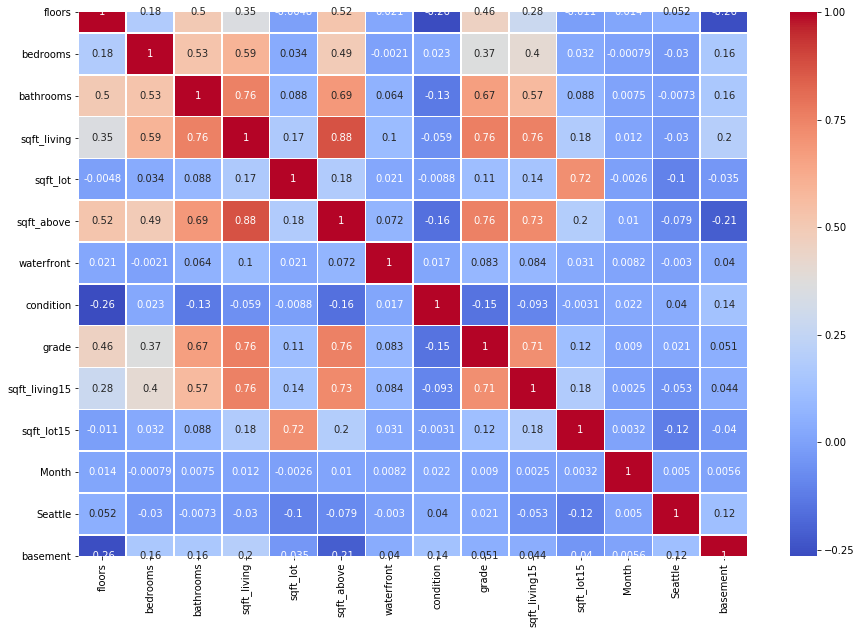

In [26]:
variables = ['floors', 'bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'sqft_above', 'waterfront','condition','grade','sqft_living15','sqft_lot15','Month','Seattle','season','basement']
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df[variables].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

Several things are already noticable. There is minor correlation between bathrooms, grade, and bedrooms, which is expected. Living in the Seattle area, having a basement, and having more floors are good indicators of price.

Also sqft_above seems to have strong correlation with multiple columns so it should be eliminated.

In [27]:
df.drop(['sqft_living'], axis=1, inplace=True)

## Checking for and removing outliers

Outliers will skew the data, so getting rid of a few outliers should help in that regard

In [28]:
df.loc[df['sqft_lot15']>500000]

,id,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,condition,grade,...,sqft_living15,sqft_lot15,Year,Month,Day,Julian,Seattle,season,basement,logprice
9705,225079036,1/7/2015,937500.0,4,4.0,871200,2.0,0.0,3,11,...,3420,871200,2015,1,7,2457029.5,0,Winter,1,13.750972
13451,3420069060,11/7/2014,790000.0,3,2.5,432036,1.5,0.0,3,10,...,1500,560617,2014,11,7,2456968.5,0,Autumn,0,13.579788
20436,1125079111,4/15/2015,1600000.0,4,5.5,871200,2.0,0.0,3,11,...,1280,858132,2015,4,15,2457127.5,0,Spring,0,14.285514


In [29]:
df.loc[df['price']>6000000]

,id,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,condition,grade,...,sqft_living15,sqft_lot15,Year,Month,Day,Julian,Seattle,season,basement,logprice
3910,9808700762,6/11/2014,7060000.0,5,4.50,37325,2.0,1.0,3,11,...,3930,25449,2014,6,11,2456819.5,0,Spring,1,15.769956
7245,6762700020,10/13/2014,7700000.0,6,8.00,27600,2.5,0.0,4,13,...,3940,8800,2014,10,13,2456943.5,1,Autumn,1,15.856731
9245,9208900037,9/19/2014,6890000.0,6,7.75,31374,2.0,0.0,3,13,...,4540,42730,2014,9,19,2456919.5,0,Summer,1,15.745582


In [30]:
df.loc[df['sqft_lot']>1000000]

,id,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,condition,grade,...,sqft_living15,sqft_lot15,Year,Month,Day,Julian,Seattle,season,basement,logprice
1717,1020069017,3/27/2015,700000.0,4,1.00,1651359,1.0,0.0,4,6,...,2560,425581,2015,3,27,2457108.5,0,Winter,0,13.458836
7640,2623069031,5/21/2014,542500.0,5,3.25,1074218,1.5,0.0,5,8,...,2450,68825,2014,5,21,2456798.5,0,Spring,1,13.203943
7762,2323089009,1/19/2015,855000.0,4,3.50,1024068,2.0,0.0,3,10,...,1830,11700,2015,1,19,2457041.5,0,Winter,0,13.658857
17305,3326079016,5/4/2015,190000.0,2,1.00,1164794,1.0,0.0,2,5,...,1680,16730,2015,5,4,2457146.5,0,Spring,0,12.154779


In [31]:
df.drop(index=[9509,13177,20010,3846,7105,9059,1687,7489,7610,16940], inplace=True)

## Creating a function to examine a histogram and Q-Q plot, then plotting

In [32]:
def diagnostic_plot(df, var):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[var].hist(bins=30)
    plt.title(var)
    plt.subplot(1, 2, 2)
    stats.probplot(df[var], dist="norm", plot=plt)
    plt.title(var)
    plt.tight_layout()
    plt.show()

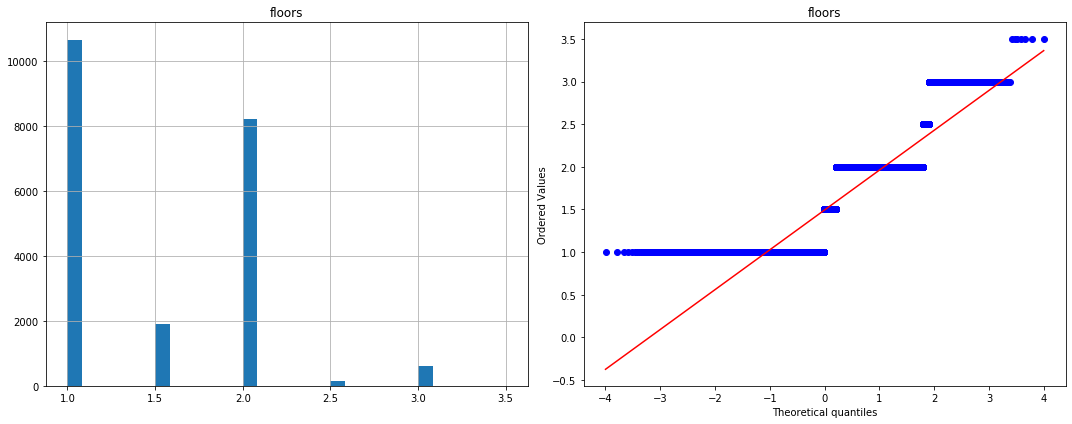

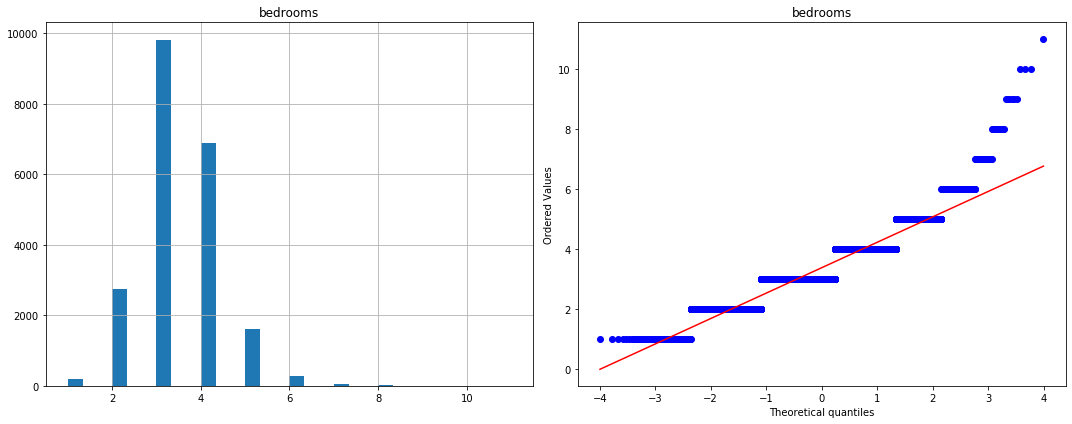

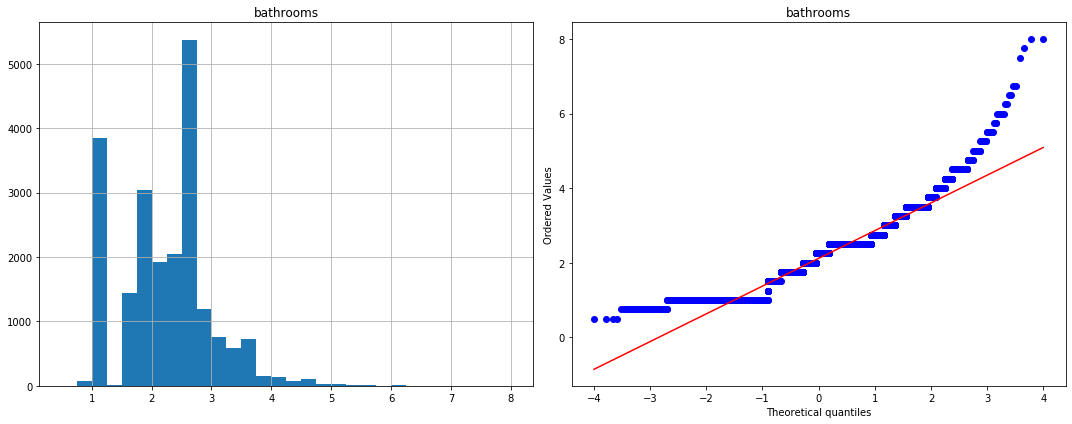

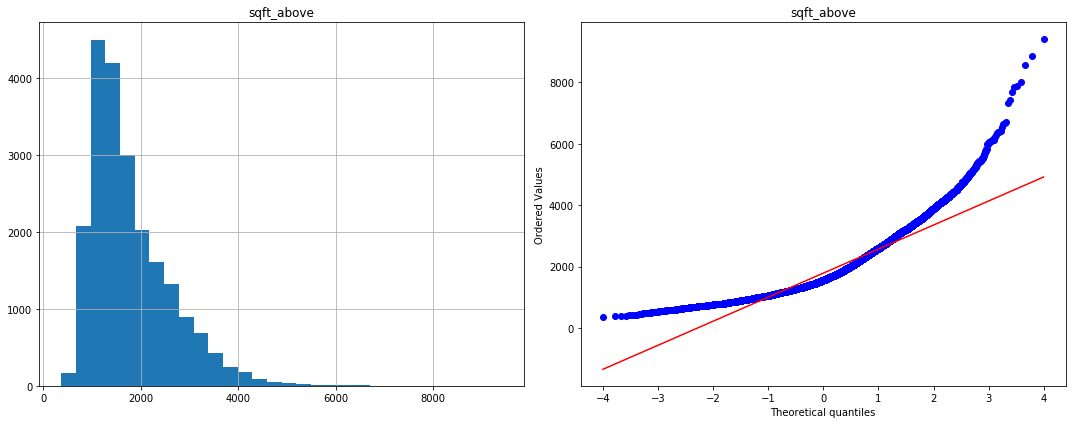

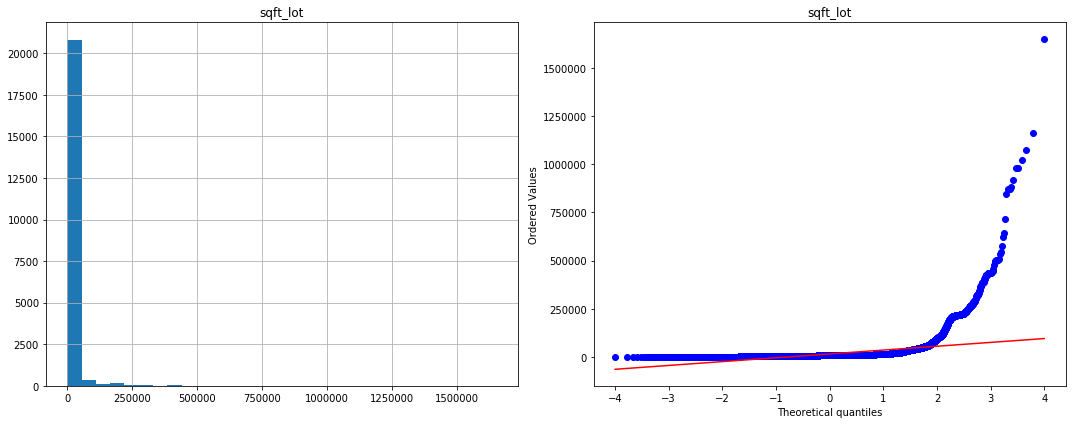

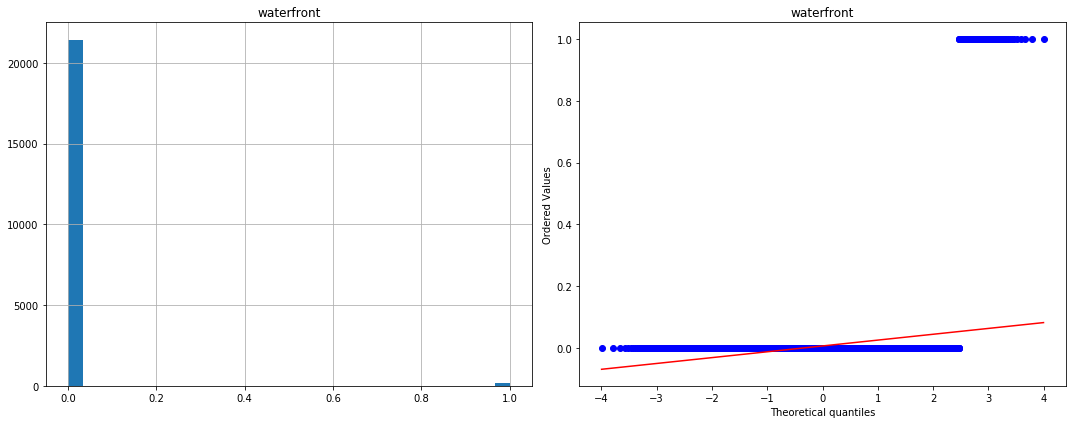

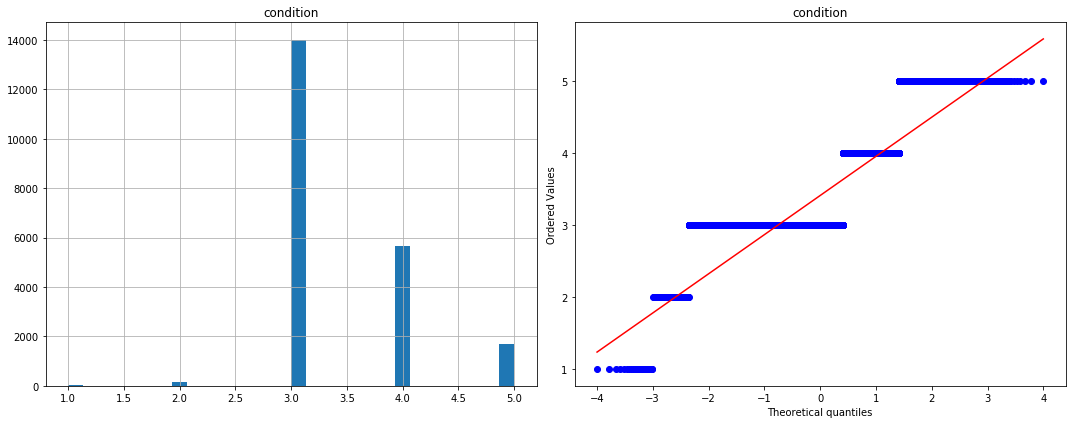

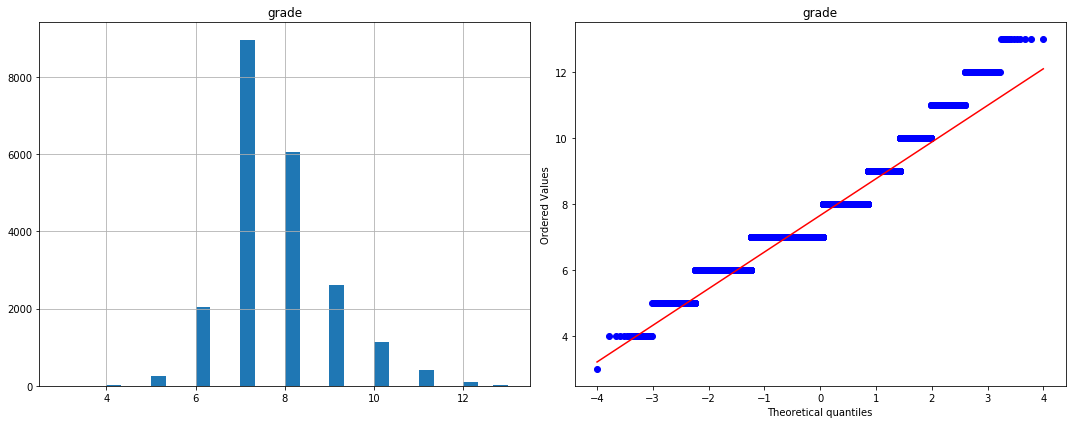

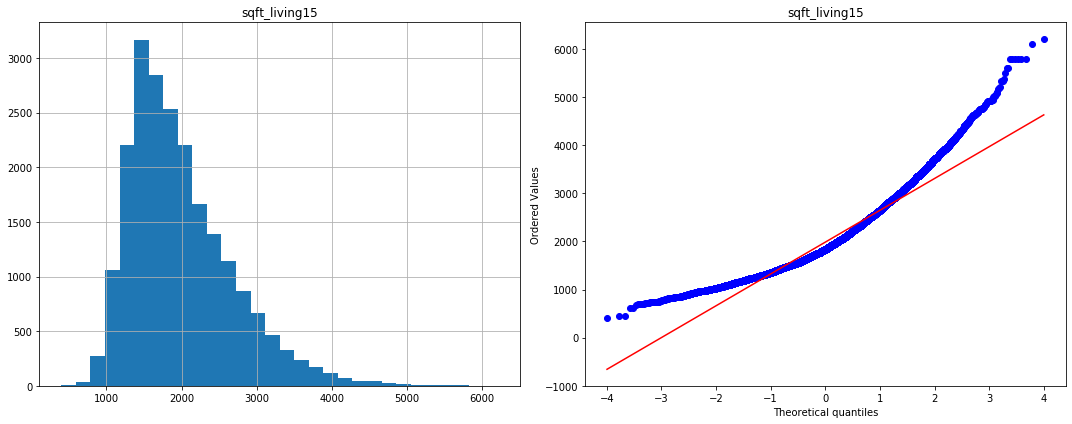

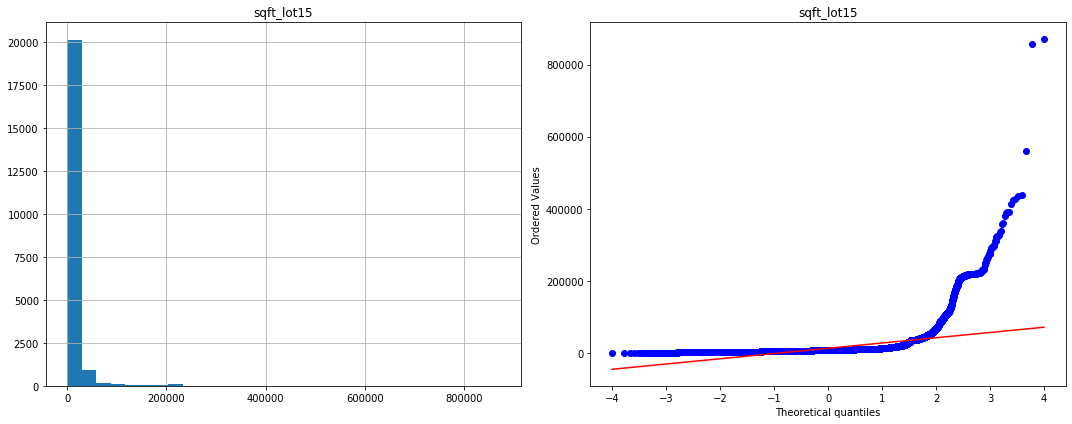

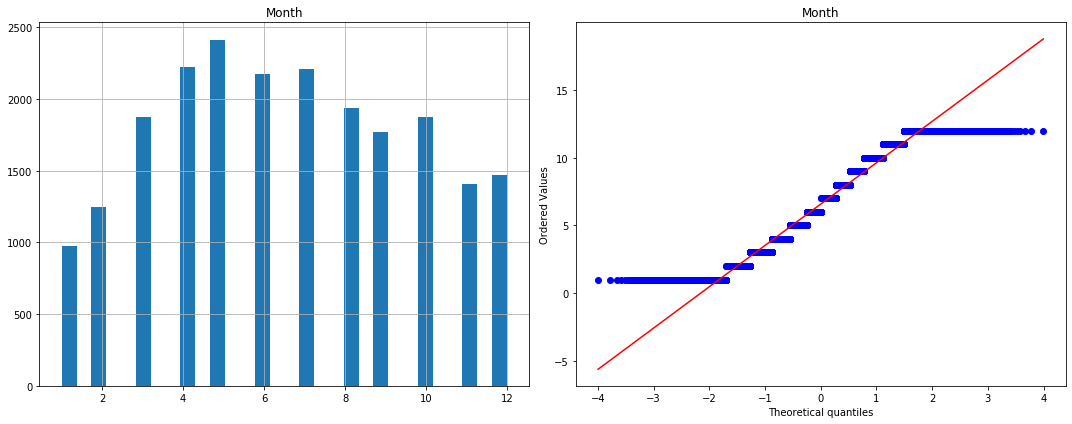

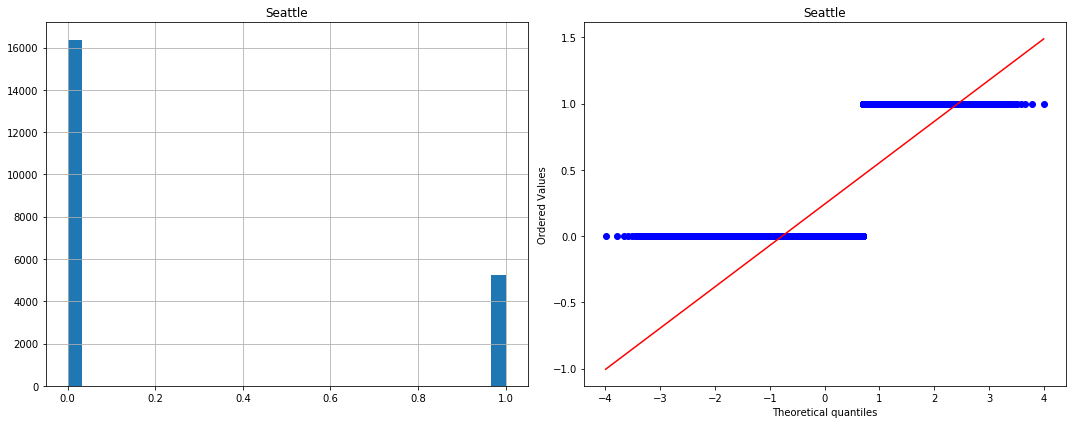

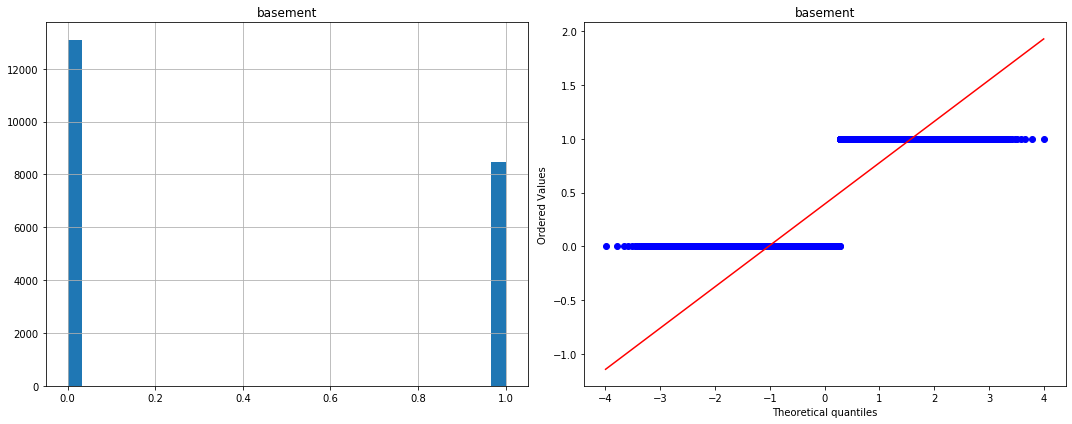

In [33]:
variables = ['floors', 'bedrooms', 'bathrooms', 'sqft_above','sqft_lot','waterfront','condition','grade','sqft_living15','sqft_lot15','Month','Seattle','basement']
for col in df[variables]:
    diagnostic_plot(df,col)

# Using Linear Regression to Predict Prices

## Dropping columns that are no longer useful

In [34]:
df.drop(['id', 'date', 'lat', 'long'], axis=1, inplace=True)

## Creating dummy variables from categorical variables

In [35]:
categoricals = ['condition','grade','zipcode','basement','season','waterfront','Month']

In [36]:
conditiondum = pd.get_dummies(df["condition"], prefix="condition", drop_first=True)
gradedum = pd.get_dummies(df["grade"], prefix="grade", drop_first=True)
zipcodedum = pd.get_dummies(df["zipcode"], prefix="zipcode", drop_first=True)
basementdum = pd.get_dummies(df["basement"], prefix="basement", drop_first=True)
seasondum = pd.get_dummies(df["season"], prefix="season", drop_first=True)
waterfrontdum = pd.get_dummies(df["waterfront"], prefix="waterfront", drop_first=True)
monthdum = pd.get_dummies(df["Month"], prefix="month", drop_first=True)
olddf = df

df.drop(categoricals, axis=1, inplace = True)
df = pd.concat([df, conditiondum, gradedum, zipcodedum, basementdum, seasondum, waterfrontdum, monthdum], axis=1)

## Looking for multicollinearity

This funtion shows a large amount of subplots

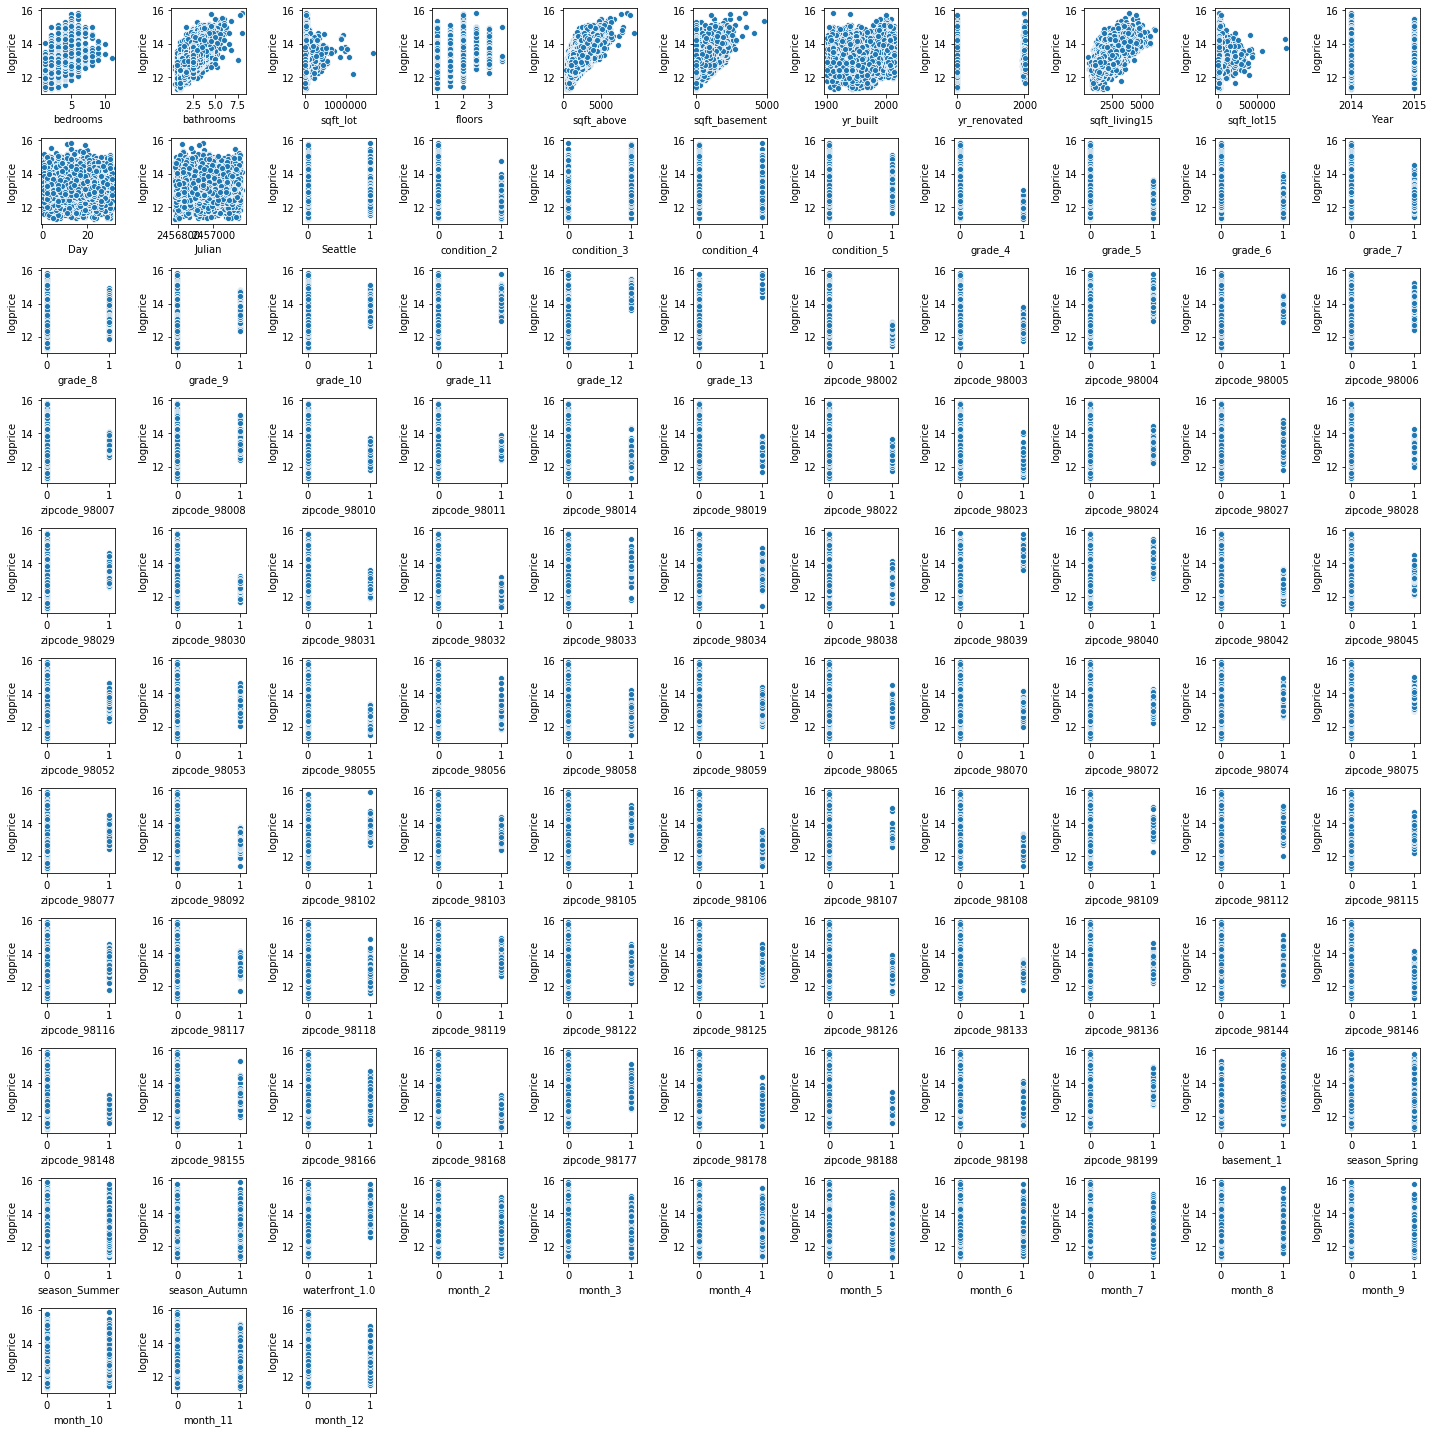

In [37]:
noprice = df.drop(['price', 'logprice'], axis = 1)

plt.figure(1, figsize=(20,20))
        
def multi_scatter_plot(x):
    sns.scatterplot(x, y="logprice", data=df) #iterating over dataframe minus price columns, adding subplots

for index, col in enumerate(noprice.columns, start=1):

    plt.subplot(11, 11,index)

    multi_scatter_plot(col)
plt.tight_layout()
plt.show()

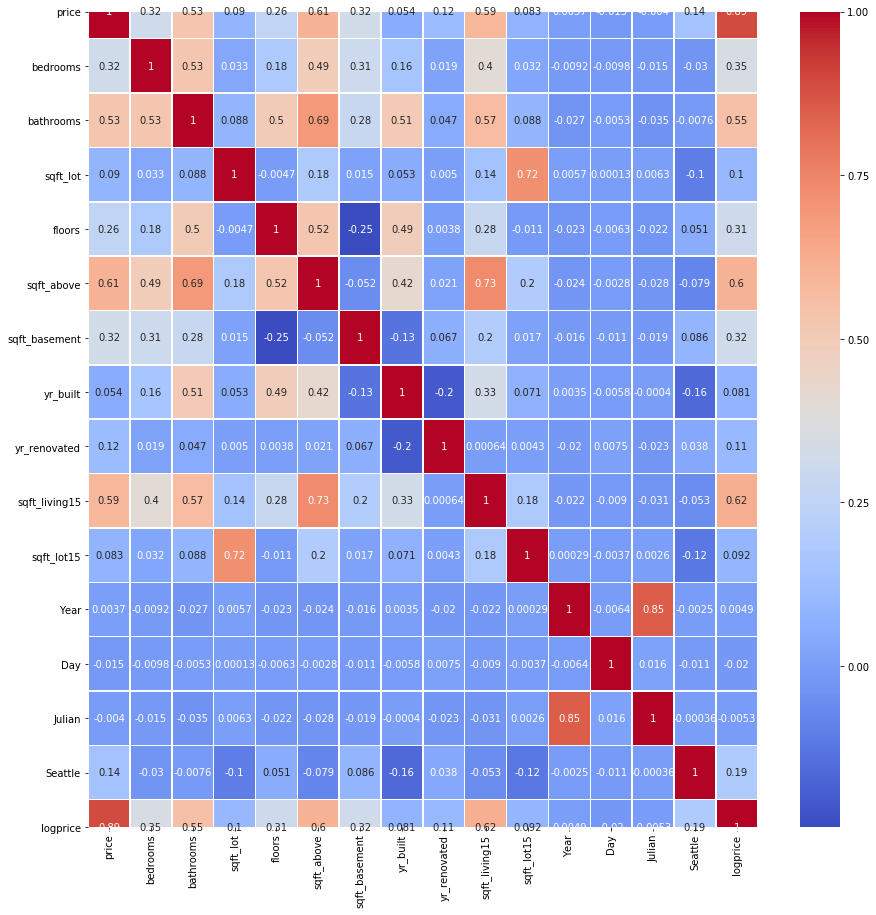

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(olddf.corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

The correlation is not too significant (under .75)

## Log transforming some data to normalize

Normalizing the data makes it easier to visualize

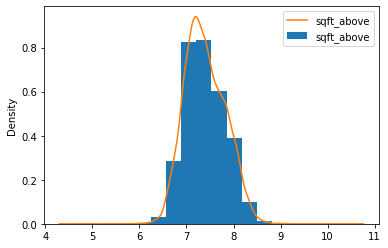

In [39]:
df['sqft_above'] = np.log(df['sqft_above'])
df['sqft_above'].plot.hist(density=True )
df['sqft_above'].plot.kde(label='sqft_above')
plt.legend()
plt.show()

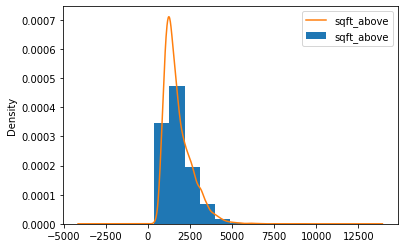

In [40]:
# This is how to reverse the log function for future reference
df['sqft_above'] = np.exp(df['sqft_above'])
df['sqft_above'].plot.hist(density=True )
df['sqft_above'].plot.kde(label='sqft_above')
plt.legend()
plt.show()

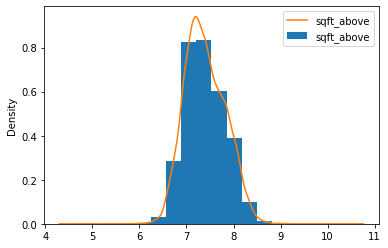

In [41]:
df['sqft_above'] = np.log(df['sqft_above'])
df['sqft_above'].plot.hist(density=True )
df['sqft_above'].plot.kde(label='sqft_above')
plt.legend()
plt.show()

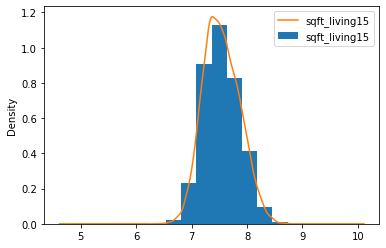

In [42]:
df['sqft_living15'] = np.log(df['sqft_living15'])
df['sqft_living15'].plot.hist(density=True )
df['sqft_living15'].plot.kde(label='sqft_living15')
plt.legend()
plt.show()

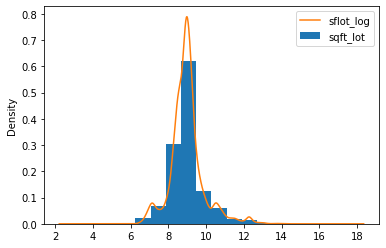

In [43]:
df['sqft_lot'] = np.log(df['sqft_lot'])
df['sqft_lot'].plot.hist(density=True )
df['sqft_lot'].plot.kde(label='sflot_log')
plt.legend()
plt.show()

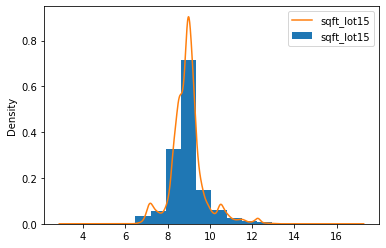

In [44]:
df['sqft_lot15'] = np.log(df['sqft_lot15'])
df['sqft_lot15'].plot.hist(density=True )
df['sqft_lot15'].plot.kde(label='sqft_lot15')
plt.legend()
plt.show()

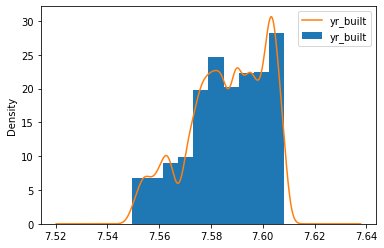

In [45]:
df['yr_built'] = np.log(df['yr_built'])
df['yr_built'].plot.hist(density=True )
df['yr_built'].plot.kde(label='yr_built')
plt.legend()
plt.show()

Square foot living 15, square foot above, square foot lot, square foot lot 15, and year built were transformed along with the price, so they will need to be un-transformed later

# Performing Regression Diagnostics

## Train test split

The train test split is used to validate our regression model

In [46]:
X = df.drop(['logprice'], axis=1)
y = df['logprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
x_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_fit = sm.OLS(y_train, x_train).fit()
results_df = pd.concat([x_train, y_train], axis=1)
model_fit.summary()

C:\Users\reube\.conda\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2164.
Date:                Sat, 01 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:52:21   Log-Likelihood:                 9822.2
No. Observations:               17268   AIC:                        -1.942e+04
Df Residuals:                   17158   BIC:                        -1.857e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.789e-05      7e-06     -6.840      0.000   -6.16e-05   -3.42e-05
price           7.447e-07   6.67e-09    111.635      0.000    7.32e-07    7.58e-07
bedrooms          -0.0031      0.002     -1.920      0.055      -0.006    6.31e-05
bathrooms          0.0097      0.003      3.805      0.000       0.005       0.015
sqft_lot           0.0479      0.003     15.344      0.000       0.042       0.054
floors            -0.0067      0.003     -2.062      0.039      -0.013      -0.000
sqft_above         0.2159      0.006     34.206      0.000       0.204       0.228
sqft_basement   -7.52e-07   4.81e-06     -0.156      0.876   -1.02e-05    8.67e-06
yr_built          -0.1156      0.126     -0.916      0.360      -0.363       0.132
yr_renovated    1.773e-05   3.13e-06      5.670      0.000    1.16e-05    2.39e-05
sqft_living15      0.1528      0.006     27.085      0.000       0.142       0.164
sqft_lot15        -0.0110      0.003     -3.213      0.001      -0.018      -0.004
Year               0.0747      0.010      7.267      0.000       0.055       0.095
Day             2.826e-05      0.000      0.224      0.823      -0.000       0.000
Julian         -5.718e-05   8.45e-06     -6.765      0.000   -7.38e-05   -4.06e-05
Seattle            0.4411      0.009     51.471      0.000       0.424       0.458
condition_2        0.1121      0.033      3.445      0.001       0.048       0.176
condition_3        0.2383      0.030      7.832      0.000       0.179       0.298
condition_4        0.2632      0.030      8.647      0.000       0.204       0.323
condition_5        0.3010      0.031      9.831      0.000       0.241       0.361
grade_4           -0.3692      0.141     -2.617      0.009      -0.646      -0.093
grade_5           -0.3467      0.138     -2.507      0.012      -0.618      -0.076
grade_6           -0.2681      0.138     -1.942      0.052      -0.539       0.002
grade_7           -0.1812      0.138     -1.312      0.189      -0.452       0.089
grade_8           -0.1129      0.138     -0.817      0.414      -0.384       0.158
grade_9           -0.0660      0.138     -0.478      0.633      -0.337       0.205
grade_10          -0.0911      0.138     -0.659      0.510      -0.362       0.180
grade_11          -0.1760      0.139     -1.270      0.204      -0.448       0.096
grade_12          -0.4572      0.140     -3.276      0.001      -0.731      -0.184
grade_13          -1.3211      0.146     -9.036      0.000      -1.608      -1.035
zipcode_98002     -0.0113      0.014     -0.836      0.403      -0.038       0.015
zipcode_98003     -0.4272      0.009    -45.139      0.000      -0.446      -0.409
zipcode_98004      0.5259      0.013     39.816      0.000       0.500       0.552
zipcode_98005      0.0444      0.011      3.959      0.000       0.022       0.066
zipcode_9800

In [47]:
df.columns[1:]

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=114)

In [48]:
lr = LinearRegression()

#fitting model on training data
lr.fit(X_train,y_train)

#predicting on the training data
y_pred=lr.predict(X_train)

#calculating score on the linear regression model on the training set
r_score=lr.score(X_train,y_train)
r_score

0.9322028605156583

The r score is very good. I don't believe it's a result of overfitting because I haven't used polynomial regression. It may be due to the way the log of the price normalized so well.

## Reducing number of dimensions by Z-Score

In [69]:
X_train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=114)

In [71]:
for x in X_train.columns:
    stats.zscore(x)

IndexError: tuple index out of range

## Evaluating RMSE

In [49]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
y_hat_train = lr.predict(X_train)

In [51]:
print(X_test.shape)
print(X_train.shape)

(4318, 115)
(17268, 114)


These need to be the same width (columns) so the "const" column will be dropped from X_test

In [52]:
X_test.pop('const')

701      1.0
3043     1.0
1560     1.0
2764     1.0
9817     1.0
        ... 
19804    1.0
6667     1.0
14608    1.0
98       1.0
21301    1.0
Name: const, Length: 4318, dtype: float64

In [53]:
y_hat_test = lr.predict(X_test)

In [54]:
# waterfront caused an error, possibly related to its name'1.0', so it needs to be dropped
df.drop(['waterfront_1.0'], axis=1, inplace=True)

In [55]:
# Here I'm getting the rsquared values so that I can decide which variables are the best predictors
col_names = df.describe().columns.drop(['logprice'])
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Housing: Price~" + val)
    print ("------------------------------")

    f = 'price~' + val
    model = ols(formula=f, data=df).fit()
    X_new = pd.DataFrame({val: [df[val].min(), df[val].max()]});
    preds = model.predict(X_new)
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    # param[0] is slope and param[1] is intercept
    print(results[idx+1])

Housing: Price~price
------------------------------
['price', 1.0, 1.3960743672214448e-10, 1.0000000000000069, 0.0]
Housing: Price~bedrooms
------------------------------
['bedrooms', 0.0997760074036067, 107390.87295676896, 128395.82454362784, 0.0]
Housing: Price~bathrooms
------------------------------
['bathrooms', 0.2766166939540696, 8607.383815125542, 251308.73596791917, 0.0]
Housing: Price~sqft_lot
------------------------------
['sqft_lot', 0.02610213943295614, -51337.36426081807, 65817.92118362738, 3.651939510098422e-126]
Housing: Price~floors
------------------------------
['floors', 0.06601392529244854, 278931.2672639546, 174974.48220517757, 0.0]
Housing: Price~sqft_above
------------------------------
['sqft_above', 0.2944832272227227, -2911695.4270091513, 466793.3187613088, 0.0]
Housing: Price~sqft_basement
------------------------------
['sqft_basement', 0.10491107200375127, 461910.44218315295, 268.92550447869115, 0.0]
Housing: Price~yr_built
------------------------------


['zipcode_98056', 0.00202642784305207, 542649.4940982055, -121754.01872874651, 3.671065827623965e-11]
Housing: Price~zipcode_98058
------------------------------
['zipcode_98058', 0.005561921504028344, 544380.444323506, -190761.36959822863, 5.221110862942327e-28]
Housing: Price~zipcode_98059
------------------------------
['zipcode_98059', 0.0003585247372400735, 541395.1701392184, -47769.86031015906, 0.005402258156806498]
Housing: Price~zipcode_98065
------------------------------
['zipcode_98065', 1.2343894010169443e-05, 540514.7981483219, -10885.01568078473, 0.6057393262299107]
Housing: Price~zipcode_98070
------------------------------
['zipcode_98070', 0.00010490289165543398, 540637.2980576653, -51255.28096365023, 0.13238684449951513]
Housing: Price~zipcode_98072
------------------------------
['zipcode_98072', 8.377187025754296e-05, 539978.8756627389, 30094.644483773405, 0.17872840409453375]
Housing: Price~zipcode_98074
------------------------------
['zipcode_98074', 0.0032588377

Bathrooms, sq_above, sq_basement, sqft_living15, grade_10, grade_11, have a relatively high r squared value

In [56]:
df.drop(['Year', 'month_11', 'month_12'], axis=1, inplace=True)

In [57]:
col_names = df.describe().columns.drop(['logprice'])
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Housing: Price~" + val)
    print ("------------------------------")

    f = 'price~' + val
    model = ols(formula=f, data=df).fit()
    X_new = pd.DataFrame({val: [df[val].min(), df[val].max()]});
    preds = model.predict(X_new)
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    # param[0] is slope and param[1] is intercept
    print(results[idx+1])

Housing: Price~price
------------------------------
['price', 1.0, 1.3960743672214448e-10, 1.0000000000000069, 0.0]
Housing: Price~bedrooms
------------------------------
['bedrooms', 0.0997760074036067, 107390.87295676896, 128395.82454362784, 0.0]
Housing: Price~bathrooms
------------------------------
['bathrooms', 0.2766166939540696, 8607.383815125542, 251308.73596791917, 0.0]
Housing: Price~sqft_lot
------------------------------
['sqft_lot', 0.02610213943295614, -51337.36426081807, 65817.92118362738, 3.651939510098422e-126]
Housing: Price~floors
------------------------------
['floors', 0.06601392529244854, 278931.2672639546, 174974.48220517757, 0.0]
Housing: Price~sqft_above
------------------------------
['sqft_above', 0.2944832272227227, -2911695.4270091513, 466793.3187613088, 0.0]
Housing: Price~sqft_basement
------------------------------
['sqft_basement', 0.10491107200375127, 461910.44218315295, 268.92550447869115, 0.0]
Housing: Price~yr_built
------------------------------


['zipcode_98055', 0.0051907193824031195, 543327.5918472656, -239065.48363831354, 3.0318453377521746e-26]
Housing: Price~zipcode_98056
------------------------------
['zipcode_98056', 0.00202642784305207, 542649.4940982055, -121754.01872874651, 3.671065827623965e-11]
Housing: Price~zipcode_98058
------------------------------
['zipcode_98058', 0.005561921504028344, 544380.444323506, -190761.36959822863, 5.221110862942327e-28]
Housing: Price~zipcode_98059
------------------------------
['zipcode_98059', 0.0003585247372400735, 541395.1701392184, -47769.86031015906, 0.005402258156806498]
Housing: Price~zipcode_98065
------------------------------
['zipcode_98065', 1.2343894010169443e-05, 540514.7981483219, -10885.01568078473, 0.6057393262299107]
Housing: Price~zipcode_98070
------------------------------
['zipcode_98070', 0.00010490289165543398, 540637.2980576653, -51255.28096365023, 0.13238684449951513]
Housing: Price~zipcode_98072
------------------------------
['zipcode_98072', 8.377187

In [58]:
new_df = df[['logprice','sqft_above', 'bathrooms', 'zipcode_98004', 'zipcode_98112', 'month_2', 'month_4', 'condition_3', 'grade_8', 'zipcode_98011', 'zipcode_98024', 'zipcode_98034', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98107', 'zipcode_98136', 'season_Summer', 'season_Autumn', 'month_3', 'month_5','month_7','month_8', 'month_9', 'month_10']]

## Statsmodel regression

In [59]:
# refitting the model
f = 'logprice ~ sqft_above + bathrooms + Julian + bedrooms + zipcode_98004 + zipcode_98112 + month_2 + month_4 + condition_3 + grade_8 + zipcode_98024 + zipcode_98065 + zipcode_98070 + zipcode_98072 + zipcode_98107 + zipcode_98136 + season_Autumn + month_8 + month_10'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     941.7
Date:                Sat, 01 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:52:26   Log-Likelihood:                -10265.
No. Observations:               21586   AIC:                         2.057e+04
Df Residuals:                   21566   BIC:                         2.073e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -81.5827     72.362     -1.127      0.260    -223.418      60.252
sqft_above        0.5095      0.009     55.861      0.000       0.492       0.527
bathrooms         0.1947      0.005     38.459      0.000       0.185       0.205
Julian         3.685e-05   2.95e-05      1.251      0.211   -2.09e-05    9.46e-05
bedrooms         -0.0139      0.004     -3.836      0.000      -0.021      -0.007
zipcode_98004     0.7529      0.022     33.966      0.000       0.709       0.796
zipcode_98112     0.6487      0.024     27.103      0.000       0.602       0.696
month_2          -0.0317      0.012     -2.588      0.010      -0.056      -0.008
month_4           0.0550      0.011      5.156      0.000       0.034       0.076
condition_3      -0.1144      0.006    -19.851      0.000      -0.126      -0.103
grade_8           0.0006      0.006      0.095      0.925      -0.011       0.012
zipcode_98024     0.0165      0.044      0.377      0.706      -0.069       0.102
zipcode_98065    -0.1280      0.023     -5.682      0.000      -0.172      -0.084
zipcode_98070     0.0268      0.036      0.740      0.459      -0.044       0.098
zipcode_98072     0.0705      0.024      2.966      0.003       0.024       0.117
zipcode_98107     0.3473      0.024     14.349      0.000       0.300       0.395
zipcode_98136     0.2988      0.024     12.322      0.000       0.251       0.346
season_Autumn    -0.0179      0.011     -1.625      0.104      -0.039       0.004
month_8          -0.0023      0.010     -0.240      0.811      -0.021       0.016
month_10          0.0086      0.014      0.622      0.534      -0.018       0.036
==============================================================================
Omnibus:                       61.584   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.645
Skew:                           0.125   Prob(JB):                     4.11e-14
Kurtosis:                       2.922   Cond. No.                     6.71e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.71e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

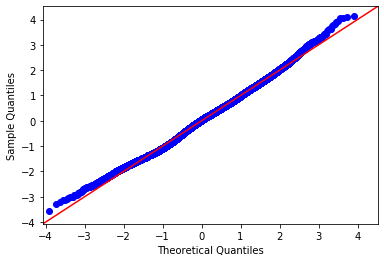

In [60]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

Checking for normality. Looks very good

## Model Validation

## Reversing Log Functions

## Fitting Model Again

In [61]:
predictions = model_fit.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

ValueError: shapes (4318,114) and (115,) not aligned: 114 (dim 1) != 115 (dim 0)

# Conclusion

The model was checked for the regression assumptions and appeared to pass. The r_squared value is somewhat low, however it the predictions compared to actual prices look reasonably linear.